# **PROYECTO FINAL**
## **Grupo 1 - Modulo 1**
## Integrantes:
> Wilson Cruz
> 
> Rolando Gonzalez
> 
> Dennis Delgado
> 
> Harold Maldonado


DIAGNÓSTICO INICIAL DE FILE_UTILS...
Probando extract_patient_info:
  RET002OD.jpg              -> ID:'002', Eye:'OD', Type:'image'
  RET002OS.jpg              -> ID:'002', Eye:'OS', Type:'image'
  RET015OD.jpg              -> ID:'015', Eye:'OD', Type:'image'
  RET123OS.jpg              -> ID:'123', Eye:'OS', Type:'image'
  RET002OD_cup_exp1.txt     -> ID:'None', Eye:'None', Type:'None'
  Opht_cont_RET002OD.jpg    -> ID:'002', Eye:'OD', Type:'contour_image'
Inicializando sistema FINAL...
Encontradas 488 imágenes en FundusImages
Datos OD cargados: 244 pacientes
Datos OS cargados: 244 pacientes
Cargando pacientes del dataset...

PRIMEROS 5 PACIENTES CARGADOS:
  1. RET002OD - ID:'002'
  2. RET002OS - ID:'002'
  3. RET004OD - ID:'004'
  4. RET004OS - ID:'004'
  5. RET005OD - ID:'005'

488 imágenes de 244 pacientes cargadas
Sistema FINAL listo!

DIAGNÓSTICO DE PARSING DE ARCHIVOS:
RET002OD.jpg              -> ID:'002', Eye:'OD', Type:'image'
RET002OS.jpg              -> ID:'002', Eye:'OS', 

Seleccione una opción (0-7):  3



 **PACIENTES DISPONIBLES:**
-----------------------------------
 002: OD, OS
 004: OD, OS
 005: OD, OS
 006: OD, OS
 007: OD, OS
 008: OD, OS
 009: OD, OS
 010: OD, OS
 013: OD, OS
 014: OD, OS
 015: OD, OS
 016: OD, OS
 018: OD, OS
 019: OD, OS
 020: OD, OS
 021: OD, OS
 023: OD, OS
 024: OD, OS
 025: OD, OS
 026: OD, OS
   ... y 224 pacientes más

Total: 488 imágenes disponibles



Ingrese ID del paciente:  005
Ingrese ojo (OD/OS):  OD



INFORMACIÓN DE IMAGEN: RET005OD
Dimensiones: 2576 x 1934 px
Modo color: RGB
Formato: JPEG
Tamaño archivo: 1,067,247 bytes
Archivos de contorno: 4
Tiene imagen con contornos: Sí

🖼️  VISUALIZANDO IMAGEN: RET005OD
Presione 'q' para cerrar la ventana y continuar...


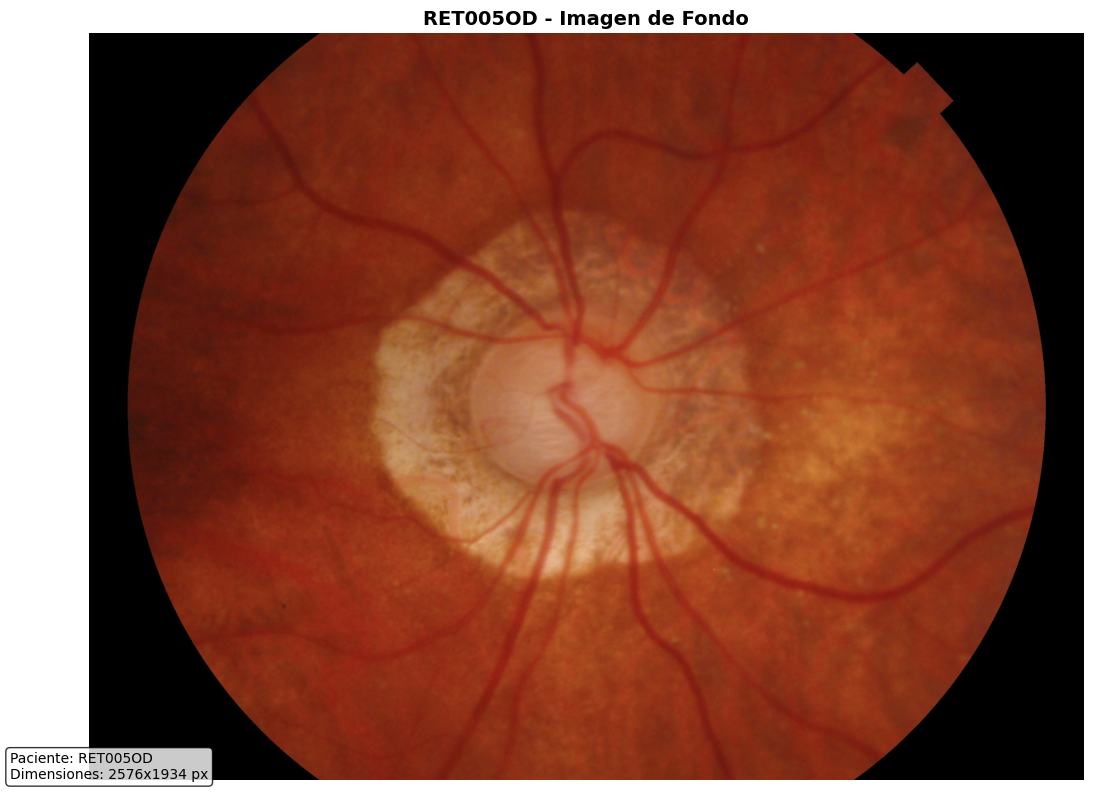


Presione Enter para continuar... 

⏎ Presione Enter para continuar... 0



SISTEMA DE GESTIÓN DE IMÁGENES MÉDICAS - PAPILA DB
1. Listar pacientes (primeros 20)
2. Buscar paciente
3. Ver información de imagen
4. Ver datos clínicos
5. Estadísticas del dataset
6. Mostrar pacientes disponibles
0. Salir
------------------------------------------------------------


In [ ]:
# SISTEMA DE IMAGENES MEDICAS 
import sys
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

sys.path.append('modules')

from modules.image_manager import ImageManager
from modules.metadata_manager import MetadataManager

class MedicalImageSystem:
    def __init__(self, data_path: str):
        """
        Inicializar el sistema
        
        Args:
            data_path (str): Ruta al dataset
        """
        self.data_path = Path(data_path)
        self.image_manager = ImageManager(self.data_path)
        self.metadata_manager = MetadataManager(self.data_path)
        self.available_patients = self._load_available_patients()
    
    def _debug_file_parsing(self):
        """Diagnóstico de cómo se están parseando los nombres de archivo"""
        print("\nDIAGNÓSTICO DE PARSING DE ARCHIVOS:")
        print("=" * 50)
        
        from modules.file_utils import FileUtils
        
        # Probar con algunos nombres de archivo de ejemplo
        test_files = [
            "RET002OD.jpg",
            "RET002OS.jpg", 
            "RET015OD.jpg",
            "RET123OS.jpg",
            "RET002OD_cup_exp1.txt",
            "Opht_cont_RET002OD.jpg"
        ]
        
        for test_file in test_files:
            patient_id, eye, file_type = FileUtils.extract_patient_info(test_file)
            print(f"{test_file:<25} -> ID:'{patient_id}', Eye:'{eye}', Type:'{file_type}'")
    
    
    def _load_available_patients(self):
        """Cargar y mostrar pacientes disponibles automáticamente"""
        patients = self.image_manager.list_patients()
        available = []
        
        print("Cargando pacientes del dataset...")
        
        # DIAGNÓSTICO: Ver los primeros pacientes cargados
        print("\nPRIMEROS 5 PACIENTES CARGADOS:")
        for i, patient in enumerate(patients[:5]):
            print(f"  {i+1}. RET{patient['patient_id']}{patient['eye']} - ID:'{patient['patient_id']}'")
        
        for patient in patients:
            available.append((patient['patient_id'], patient['eye']))
        
        # Mostrar resumen
        unique_ids = set(pid for pid, eye in available)
        print(f"\n{len(available)} imágenes de {len(unique_ids)} pacientes cargadas")
        
        return available
    
    def _show_available_patients(self):
        """Mostrar pacientes disponibles de forma organizada"""
        print("\n **PACIENTES DISPONIBLES:**")
        print("-" * 35)
        
        from collections import defaultdict
        patient_eyes = defaultdict(list)
        for pid, eye in self.available_patients:
            patient_eyes[pid].append(eye)
        
        # Mostrar solo los primeros 20 para no saturar
        count = 0
        for pid in sorted(patient_eyes.keys(), key=lambda x: int(x)):
            if count < 20:
                eyes = patient_eyes[pid]
                print(f" {pid}: {', '.join(eyes)}")
                count += 1
            else:
                remaining = len(patient_eyes) - 20
                print(f"   ... y {remaining} pacientes más")
                break
        
        print(f"\nTotal: {len(self.available_patients)} imágenes disponibles")
    
    def display_menu(self):
        """Mostrar menú principal"""
        print("\n" + "="*60)
        print("SISTEMA DE GESTIÓN DE IMÁGENES MÉDICAS - PAPILA DB")
        print("="*60)
        print("1. Listar pacientes (primeros 20)")
        print("2. Buscar paciente")
        print("3. Ver información de imagen")
        print("4. Ver datos clínicos")
        print("5. Estadísticas del dataset")
        print("6. Mostrar pacientes disponibles")
        print("0. Salir")
        print("-"*60)
    
    def list_patients(self):
        """Listar todos los pacientes"""
        patients = self.image_manager.list_patients()
        
        if not patients:
            print("No se encontraron pacientes.")
            return
        
        print(f"\nTotal de pacientes: {len(patients)}")
        print("Mostrando primeros 20 pacientes:")
        print("=" * 80)
        print(f"{'ID':<10} {'Ojo':<6} {'Contornos':<10} {'Img Contornos':<14} {'Archivo':<20}")
        print("-" * 80)
        
        for patient in patients[:20]:
            contour_icon = "->hay<-" if patient['has_contour_image'] else ">no hay<-"
            print(f"RET{patient['patient_id']:<7} {patient['eye']:<6} "
                  f"{patient['contour_count']:<10} {contour_icon:<14} "
                  f"{Path(patient['image_path']).name:<20}")
        
        if len(patients) > 20:
            print(f"... y {len(patients) - 20} pacientes más")
    
    def search_patient(self):
        """Buscar paciente con guía mejorada"""
        self._show_available_patients()
        
        patient_id = input("\nIngrese ID del paciente: ").strip()
        eye = input("Ingrese ojo (OD/OS): ").strip().upper()
        
        # Validaciones
        if not patient_id:
            print("Error: Debe ingresar un ID")
            return
        
        if eye not in ['OD', 'OS']:
            print("Error: El ojo debe ser 'OD' o 'OS'")
            return
        
        # Verificar si existe
        if (patient_id, eye) not in self.available_patients:
            print(f"Paciente RET{patient_id}{eye} no encontrado")
            print("Use la lista de arriba para seleccionar un paciente válido")
            
            # Sugerir alternativas similares
            suggestions = [(pid, e) for pid, e in self.available_patients 
                          if pid == patient_id or e == eye]
            if suggestions:
                print("   ¿Quizás quisiste decir?")
                for pid, e in suggestions:
                    print(f"   • RET{pid}{e}")
            return
        
        # Si existe, mostrar información
        patient = self.image_manager.get_patient(patient_id, eye)
        if patient:
            print(f"\n**PACIENTE ENCONTRADO:** RET{patient_id}{eye}")
            print("=" * 50)
            print(f"Imagen: {patient.image_path.name}")
            print(f"Contornos: {len(patient.contour_paths)} archivos")
            print(f"Imagen con contornos: {'Sí' if patient.contour_image_paths else 'No'}")
            
            # Mostrar archivos de contorno específicos
            if patient.contour_paths:
                print("\nArchivos de contorno:")
                for contour in patient.contour_paths[:4]:  # Mostrar máximo 4
                    contour_type = "disco" if "disc" in contour.name else "copa"
                    expert = contour.name.split('_')[-1].replace('.txt', '')
                    print(f"   • {contour.name} ({contour_type} - {expert})")
                if len(patient.contour_paths) > 4:
                    print(f"   ... y {len(patient.contour_paths) - 4} más")
        
    def show_image_info(self):
        """Mostrar información de imagen Y visualizarla"""
        self._show_available_patients()
        
        patient_id = input("\nIngrese ID del paciente: ").strip()
        eye = input("Ingrese ojo (OD/OS): ").strip().upper()
        
        if (patient_id, eye) not in self.available_patients:
            print(f"Paciente RET{patient_id}{eye} no encontrado")
            return
        
        info = self.image_manager.get_image_info(patient_id, eye)
        if info:
            print(f"\nINFORMACIÓN DE IMAGEN: RET{patient_id}{eye}")
            print("=" * 50)
            print(f"Dimensiones: {info['dimensions'][0]} x {info['dimensions'][1]} px")
            print(f"Modo color: {info['mode']}")
            print(f"Formato: {info['format']}")
            print(f"Tamaño archivo: {info['file_size']:,} bytes")
            print(f"Archivos de contorno: {info['contour_files']}")
            print(f"Tiene imagen con contornos: {'Sí' if info['has_contour_image'] else 'No'}")
            
            # CARGAR Y MOSTRAR LA IMAGEN
            image = self.image_manager.load_image(patient_id, eye)
            if image:
                print(f"\n🖼️  VISUALIZANDO IMAGEN: RET{patient_id}{eye}")
                print("Presione 'q' para cerrar la ventana y continuar...")
                
                # Convertir PIL Image a numpy array para matplotlib
                img_array = np.array(image)
                
                # Crear figura con tamaño adecuado
                plt.figure(figsize=(12, 8))
                plt.imshow(img_array)
                plt.title(f"RET{patient_id}{eye} - Imagen de Fondo", fontsize=14, fontweight='bold')
                plt.axis('off')  # Ocultar ejes
                
                # Añadir información en la imagen
                text_str = f"Paciente: RET{patient_id}{eye}\nDimensiones: {info['dimensions'][0]}x{info['dimensions'][1]} px"
                plt.figtext(0.02, 0.02, text_str, fontsize=10, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                
                # Mostrar y esperar
                plt.tight_layout()
                plt.show(block=False)  # No bloquear la ejecución
                
                # Esperar input del usuario para continuar
                input("\nPresione Enter para continuar...")
                plt.close()  # Cerrar la ventana de la imagen
                
            else:
                print("No se pudo cargar la imagen para visualización.")
        else:
            print(f"No se pudo cargar información para RET{patient_id}{eye}")    
    
    
    def show_clinical_data(self):
        """Mostrar datos clínicos"""
        self._show_available_patients()
        
        patient_id = input("\nIngrese ID del paciente: ").strip()
        eye = input("Ingrese ojo (OD/OS): ").strip().upper()
        
        if (patient_id, eye) not in self.available_patients:
            print(f"Paciente RET{patient_id}{eye} no encontrado")
            return
        
        clinical_data = self.metadata_manager.get_patient_clinical_data(patient_id, eye)
        if clinical_data:
            print(f"\nDATOS CLÍNICOS: RET{patient_id}{eye}")
            print("=" * 40)
            for key, value in clinical_data.items():
                if pd.notna(value):
                    print(f"  {key}: {value}")
        else:
            print(f"No se encontraron datos clínicos para RET{patient_id}{eye}")
    
    def show_statistics(self):
        """Mostrar estadísticas del dataset"""
        patients = self.image_manager.list_patients()
        
        if not patients:
            print("No hay datos para mostrar estadísticas.")
            return
        
        total_patients = len(patients)
        od_count = sum(1 for p in patients if p['eye'] == 'OD')
        os_count = sum(1 for p in patients if p['eye'] == 'OS')
        total_contours = sum(p['contour_count'] for p in patients)
        patients_with_contours = sum(1 for p in patients if p['contour_count'] > 0)
        patients_with_contour_images = sum(1 for p in patients if p['has_contour_image'])
        
        print("\nESTADÍSTICAS DEL DATASET PAPILA DB")
        print("=" * 45)
        print(f"Total de imágenes: {total_patients}")
        print(f"Ojos derechos (OD): {od_count}")
        print(f"Ojos izquierdos (OS): {os_count}")
        print(f"Total de archivos de contorno: {total_contours}")
        print(f"Promedio de contornos por imagen: {total_contours/total_patients:.1f}")
        print(f"Imágenes con contornos: {patients_with_contours}/{total_patients}")
        print(f"Imágenes con contornos visuales: {patients_with_contour_images}/{total_patients}")
    
    def show_available_patients(self):
        """Mostrar pacientes disponibles"""
        self._show_available_patients()
    
    def run(self):
        """Ejecutar el sistema principal"""
        print("Sistema de gestión de imágenes médicas inicializado!")
        print(f"{len(self.available_patients)} imágenes cargadas")
        
        while True:
            self.display_menu()
            choice = input("Seleccione una opción (0-7): ").strip()
            
            try:
                if choice == '1':
                    self.list_patients()
                elif choice == '2':
                    self.search_patient()
                elif choice == '3':
                    self.show_image_info()
                elif choice == '4':
                    self.show_clinical_data()
                elif choice == '5':
                    self.show_statistics()
                elif choice == '6':
                    self.show_available_patients()
                elif choice == '0':
                    print("\n¡Hasta luego! Gracias por usar el sistema.")
                    break
                else:
                    print("-> Opción no válida. Por favor, seleccione 0-6. <-")
            except Exception as e:
                print(f"Error: {e}")
            
            if choice != '0':
                input("\n⏎ Presione Enter para continuar...")


# DIAGNÓSTICO INMEDIATO DE FILE_UTILS
print("DIAGNÓSTICO INICIAL DE FILE_UTILS...")
from modules.file_utils import FileUtils

# Probar la función extract_patient_info
test_cases = [
    "RET002OD.jpg",
    "RET002OS.jpg",
    "RET015OD.jpg", 
    "RET123OS.jpg",
    "RET002OD_cup_exp1.txt",
    "Opht_cont_RET002OD.jpg"
]

print("Probando extract_patient_info:")
for test_case in test_cases:
    pid, eye, ftype = FileUtils.extract_patient_info(test_case)
    print(f"  {test_case:<25} -> ID:'{pid}', Eye:'{eye}', Type:'{ftype}'")


# INICIALIZACIÓN FINAL
print("Inicializando sistema FINAL...")
system_final = MedicalImageSystem("data/PapilaDB-PAPILA")
print("Sistema FINAL listo!")

# Ejecutar diagnóstico adicional
system_final._debug_file_parsing()

system_final.run()

# Actualizado nuevo de nuevo.